# Tugas Crawling_berita_Kompas
*   Nama : Muhammad Adam Zaky Jiddyansah
*   NIM : 210411100234
*   Kelas : Penambangan dan Pencarian Web B



## Menginstall dan mengimport library yang dibutuhkan
Libraries yang Digunakan
*   BeautifulSoup (bs4): Library untuk melakukan web scraping dan ekstraksi data HTML.
*   Requests: Library untuk membuat permintaan HTTP ke situs web dan mendapatkan konten halaman.
*   Pandas (pd): Library untuk mengelola dan menyimpan data dalam format CSV.


In [34]:
from bs4 import BeautifulSoup as soup
import requests
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt

In [35]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Web Scraping Berita Kompas dan Penyimpanan ke Google Drive
Kode ini menggunakan teknik web scraping untuk mengumpulkan judul dan isi berita dari 200 halaman indeks situs Kompas.com. Berikut adalah penjelasan komponen utama dari kode tersebut:

**Proses Web Scraping dan menyimpan data**
*   Iterasi sebanyak 200 halaman indeks(tergantung indeks pada website) di situs Kompas.com.
*   Untuk setiap halaman, melakukan permintaan HTTP dan mendapatkan konten HTML.
*   Menggunakan BeautifulSoup untuk mengekstrak daftar berita dari halaman tersebut.
*   Untuk setiap berita, mengakses halaman individu untuk mengambil judul dan isi berita.
*   Data judul dan isi berita ditambahkan ke dalam dictionary csv.
Penyimpanan Data
*   Setelah proses scraping selesai, data disimpan dalam file CSV dengan nama "Data_BeritaKompas.csv" terlebih dahulu di environment Colab.
*   File CSV tersebut disalin ke dalam Google Drive pada path "/content/drive/My Drive/Penambangan WEB/Data/".





In [36]:
from google.colab import drive
drive.mount('/content/drive')

csv = {"Judul": [], "Berita": []}

for i in range(1, 5):
    url = "https://indeks.kompas.com/?page={}".format(i)
    client = requests.get(url)
    page_html = client.content
    page_soup = soup(page_html, "html.parser")
    berita = page_soup.findAll("div", {"class": "latest--indeks mt2 clearfix"})

    for h in berita:
        r = requests.get(h.select_one('a.article__link')['href'])
        page = soup(r.content, "html.parser")
        halaman_isi = page.select_one("div", {"class": "col-bs10-10"})

        judul_berita = halaman_isi.select("h1", {"class": "read__title"})
        judul = judul_berita[0].text

        isi_berita = halaman_isi.findAll('p')
        isi = '\n'.join([p.get_text() for p in isi_berita])

        csv["Judul"].append(judul)
        csv["Berita"].append(isi)

        data = pd.DataFrame(csv)
        csv_path_drive = '/content/drive/My Drive/Penambangan WEB/Data/Data_BeritaKompas.csv'
        data.to_csv(csv_path_drive, index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import dan Membaca Data CSV
Menggunakan Pandas untuk membaca file CSV yang telah disimpan sebelumnya. File CSV tersebut berisi data judul dan isi berita dari Kompas.com yang telah di-web scrape sebelumnya, lalu menampilkan data yang telah dibaca dari file CSV dalam bentuk DataFrame untuk dapat dianalisis lebih lanjut.

In [37]:
from google.colab import drive
drive.mount('/content/drive')
file_path = "/content/drive/My Drive/Penambangan WEB/Data/Data_BeritaKompas.csv"
df = pd.read_csv(file_path)
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Judul,Berita
0,Pemprov DKI Sebut Pemindahan Kabel ke Bawah Ta...,Pemprov DKI Sebut Pemindahan Kabel ke Bawah Ta...
1,Elders Rilis Paket Konversi Motor Listrik Mura...,Elders Rilis Paket Konversi Motor Listrik Mura...
2,Ini Cerita Anak Pedagang Keliling yang Ikut II...,Ini Cerita Anak Pedagang Keliling yang Ikut II...
3,"Jadi Korban Penipuan Calo Tiket, Artis Susan S...","Jadi Korban Penipuan Calo Tiket, Artis Susan S..."


## Mengambil salah satu berita untuk menjadi sampel data yang akan dianalisis

In [38]:
Berita = df['Berita'].iloc[0]
Berita

'Pemprov DKI Sebut Pemindahan Kabel ke Bawah Tanah di Mampang Sudah 90 Persen \nTim Redaksi\nJAKARTA, KOMPAS.com - Pelaksana Tugas (Plt) Kepala Dinas Bina Marga DKI Jakarta Heru Suwondo menyebut proses pemindahan kabel jaringan utilitas di Ibu Kota ke bawah tanah di kawasan Mampang Prapatan, Jakarta Selatan, sudah 90 persen.\n"Iya untuk titik kawasan itu saja. Sudah 90 persen. Jadi yang di Mampang itu tinggal sedikit. Nanti akan bergeser lagi ke wilayah lain," ujar Heru saat dikonfirmasi, Kamis (16/11/2023).\nNamun, Heru tidak dapat memastikan target waktu penyelesaian pemindahan kabel ke seluruh sarana jaringan utilitas terpadu (SJUT) di wilayah Mampang Prapatan itu.\nBaca juga: Heru Budi Akui Sulit Rapikan Kabel Semrawut di Udara ke Bawah Tanah\nMenurut Heru, proses pemindahan ke SJUT itu terus dilakukan setiap hari sampai tidak ada lagi kabel semrawut di udara.\n"Untuk peralihan (kabel udara ke bawah tanah) yang sudah ada SJUT. Karena pindah kan tidak bisa sekaligus pindah, tapi ber

## Pra-pemrosesan Teks / Preprocessing

Mengambil teks sebagai input dan melakukan beberapa langkah pra-pemrosesan pada teks dalam bahasa Indonesia. Langkah-langkah tersebut mencakup penghapusan angka, pembersihan karakter khusus, konversi teks ke huruf kecil, penghapusan kata-kata umum (stopwords), dan penggabungan kata-kata yang telah melalui proses sebelumnya. Tujuannya adalah membersihkan dan mempersiapkan teks agar dapat digunakan lebih lanjut dalam analisis atau pemrosesan lanjutan.


In [39]:
def preprocessing(text):
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s.]', '', text)
    text = text.lower()

    stop_words = set(stopwords.words('indonesian'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]

    preprocessing_text = ' '.join(filtered_words)

    return preprocessing_text

kalimat_preprocessing = preprocessing(Berita)

kalimat = nltk.sent_tokenize(Berita)
kalimat_preprocessing = nltk.sent_tokenize(kalimat_preprocessing)

## Metode pengukuran TF-IDF
Mengonversi teks yang sudah melewati tahap pra-pemrosesan menjadi representasi matriks numerik menggunakan skema TF-IDF. Matriks ini mencerminkan bobot TF-IDF dari setiap kata dalam setiap kalimat. Setelah transformasi, DataFrame pandas dibuat untuk menyajikan matriks tersebut dengan kata-kata sebagai kolom dan setiap baris mewakili satu kalimat, menunjukkan bobot TF-IDF dari kata-kata tersebut dalam kalimat tersebut.

In [40]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix_preprocessing = tfidf_vectorizer.fit_transform(kalimat_preprocessing)

terms = tfidf_vectorizer.get_feature_names_out()
tfidf_preprocessing = pd.DataFrame(data=tfidf_matrix_preprocessing.toarray(), columns=terms)

tfidf_preprocessing

,akui,baca,bahri,bergeser,berlanjut,berproses,bertahap,bidang,bina,budi,...,tersedia,terus,tim,tinggal,titik,tugas,udara,utilitas,walter,wilayah
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.130914,0.000000,...,0.000000,0.00000,0.166386,0.000000,0.000000,0.166386,0.000000,0.119495,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.475730,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.630469,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.500193,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.393556
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.236060,0.000000,0.258619
6,0.256221,0.224268,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.256221,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.403194,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.482283,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.385925,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.48276,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Perhitungan Kemiripan Kosinus
Menghitung kemiripan kosinus antara semua pasangan kalimat menggunakan matriks TF-IDF yang telah dihasilkan sebelumnya. Kemudian, hasil kemiripan kosinus tersebut disimpan dalam DataFrame untuk kemudahan analisis.

**Rumus Perhitungan Kemiripan Kosinus:**
*   Untuk dua vektor A dan B, kemiripan kosinus dihitung dengan rumus $$ \text{Similarity}(A, B) = \frac{{A \cdot B}}{{\|A\| \cdot \|B\|}} $$

*   Di sini, ⋅ adalah operasi perkalian dot (dot product), dan ∥∥ adalah norma Euclidean. Dalam konteks ini, vektor A dan B adalah vektor representasi TF-IDF dari dua kalimat. Hasilnya adalah skalar yang menunjukkan seberapa mirip dua kalimat tersebut, dengan nilai 1 menunjukkan kemiripan sempurna.


In [41]:
cosine_sim_preprocessing = cosine_similarity(tfidf_matrix_preprocessing, tfidf_matrix_preprocessing)
cosine_sim_df = pd.DataFrame(cosine_sim_preprocessing, columns=range(len(kalimat_preprocessing)), index=range(len(kalimat_preprocessing)))
cosine_sim_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.000000,0.055984,0.291273,0.108211,0.031446,0.290086,0.213201,0.166489,0.027719,0.000000,0.030378,0.302769,0.308137,0.000000,0.296905,0.039369,0.000000,0.15238
1,0.055984,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166328,0.000000,0.000000,0.000000,0.000000,0.00000
2,0.291273,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
3,0.108211,0.000000,0.000000,1.000000,0.000000,0.106885,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071841,0.000000,0.000000,0.000000,0.000000,0.00000
4,0.031446,0.000000,0.000000,0.000000,1.000000,0.163902,0.096848,0.000000,0.083329,0.000000,0.091323,0.000000,0.068410,0.000000,0.000000,0.000000,0.000000,0.00000
5,0.290086,0.000000,0.000000,0.106885,0.163902,1.000000,0.198476,0.121712,0.054758,0.035903,0.131884,0.130581,0.171231,0.086320,0.146429,0.028425,0.000000,0.00000
6,0.213201,0.000000,0.000000,0.000000,0.096848,0.198476,1.000000,0.417520,0.085370,0.027987,0.149585,0.016921,0.210501,0.018010,0.260196,0.082784,0.000000,0.00000
7,0.166489,0.000000,0.000000,0.000000,0.000000,0.121712,0.417520,1.000000,0.000000,0.066954,0.134032,0.040480,0.141171,0.043087,0.371824,0.053009,0.000000,0.00000
8,0.027719,0.000000,0.000000,0.000000,0.083329,0.054758,0.085370,0.000000,1.000000,0.000000,0.080499,0.000000,0.074628,0.000000,0.000000,0.000000,0.000000,0.00000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.035903,0.027987,0.066954,0.000000,1.000000,0.105561,0.031882,0.187554,0.033934,0.032490,0.041749,0.000000,0.00000


## Visualisasi Hubungan Antar Kalimat Menggunakan Graf (Graph) berdasarkan Cosine Similarity
Membuat graf yang merepresentasikan hubungan antara kalimat-kalimat berdasarkan nilai cosine similarity. Setiap kalimat direpresentasikan sebagai node, dan garis yang menghubungkan dua node menunjukkan tingkat kemiripan antara kalimat tersebut. Semakin panjang dan tebal garis, semakin tinggi tingkat kemiripan antara dua kalimat. Graf ini membantu memvisualisasikan struktur hubungan antar kalimat dalam teks.

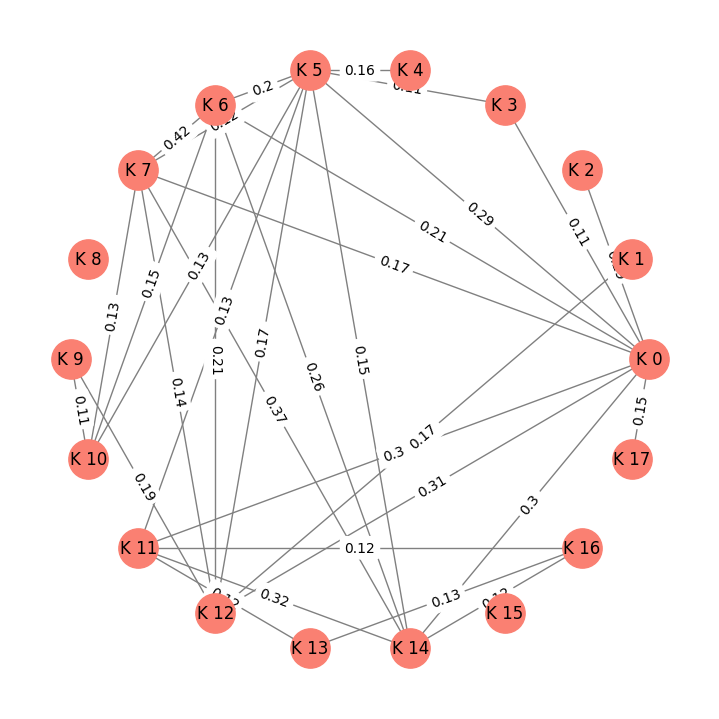

In [42]:
G_preprocessing = nx.Graph()

for i in range(len(cosine_sim_preprocessing)):
    G_preprocessing.add_node(i)

for i in range(len(cosine_sim_preprocessing)):
    for j in range(len(cosine_sim_preprocessing)):
        similarity = cosine_sim_preprocessing[i][j]
        if similarity > 0.1 and i != j:
            G_preprocessing.add_edge(i, j, weight=similarity)

pos = nx.circular_layout(G_preprocessing)

labels = {i: f'K {i}' for i in G_preprocessing.nodes()}

edge_labels = {(i, j): round(data['weight'], 2) for i, j, data in G_preprocessing.edges(data=True)}

node_size = 800

node_color = 'salmon'
edge_color = 'gray'

plt.figure(figsize=(7, 7))
nx.draw(G_preprocessing, pos, with_labels=True, labels=labels, node_size=node_size, node_color=node_color, edge_color=edge_color)
nx.draw_networkx_edge_labels(G_preprocessing, pos, edge_labels=edge_labels)
plt.show()


## Closeness

Menghitung dan menganalisis Closeness Centrality pada graf G_preprocessing.
Rumus Perhitungan Closeness Centrality:



In [43]:
# Menghitung closeness centrality
closeness_centrality_preprocessing = nx.closeness_centrality(G_preprocessing)

# Membuat DataFrame dari nilai Closeness Centrality
centrality_df_preprocessing = pd.DataFrame(closeness_centrality_preprocessing.items(), columns=['Node', 'Closeness Centrality Preprocessing'])

# Mengurutkan DataFrame berdasarkan Closeness Centrality dari yang terbesar
centrality_df_sorted_preprocessing = centrality_df_preprocessing.sort_values(by='Closeness Centrality Preprocessing', ascending=False)

# Menampilkan tabel Closeness Centrality yang telah diurutkan
centrality_df_sorted_preprocessing

,Node,Closeness Centrality Preprocessing
0,0,0.630252
5,5,0.630252
6,6,0.529412
7,7,0.529412
14,14,0.509050
12,12,0.509050
11,11,0.490196
10,10,0.426945
3,3,0.413603
17,17,0.378151


### Hasil penggunaan Closeness

In [44]:
# Mengambil tiga baris teratas dari DataFrame yang sudah diurutkan
top_three_closeness_preprocessing = centrality_df_sorted_preprocessing.head(3)

# Mendapatkan indeks node dari tiga baris teratas
top_node_indices_preprocessing = top_three_closeness_preprocessing['Node']

# Menampilkan kalimat yang sesuai dengan node-node teratas
for node_index in top_node_indices_preprocessing:
    print(f"Node Node Preprocessing {node_index}: {kalimat[node_index]}")

Node Node Preprocessing 0: Pemprov DKI Sebut Pemindahan Kabel ke Bawah Tanah di Mampang Sudah 90 Persen 
Tim Redaksi
JAKARTA, KOMPAS.com - Pelaksana Tugas (Plt) Kepala Dinas Bina Marga DKI Jakarta Heru Suwondo menyebut proses pemindahan kabel jaringan utilitas di Ibu Kota ke bawah tanah di kawasan Mampang Prapatan, Jakarta Selatan, sudah 90 persen.
Node Node Preprocessing 5: Namun, Heru tidak dapat memastikan target waktu penyelesaian pemindahan kabel ke seluruh sarana jaringan utilitas terpadu (SJUT) di wilayah Mampang Prapatan itu.
Node Node Preprocessing 6: Baca juga: Heru Budi Akui Sulit Rapikan Kabel Semrawut di Udara ke Bawah Tanah
Menurut Heru, proses pemindahan ke SJUT itu terus dilakukan setiap hari sampai tidak ada lagi kabel semrawut di udara.


##  Menghitung peringkat halaman dengan Pagerank
Rumus Perhitungan Manual PageRank:


*   PageRank mengukur pentingnya suatu node dalam sebuah graf berdasarkan seberapa banyak node lain yang mengarah ke node tersebut. Rumusnya adalah sebagai berikut:
$$PR(x) = (1 - d) + d \left( \frac{{L(y)}}{{PR(y)}} \right)$$
*   PR(x) adalah PageRank dari node x.
*   d adalah faktor damping, biasanya diatur sebagai 0,85.
*   PR(y) adalah PageRank dari node yang memiliki tautan ke node y.
*   L(y) adalah jumlah tautan keluar dari node y.
*   Iterasi dilakukan hingga konvergensi atau sejumlah iterasi tertentu. Semakin tinggi nilai PageRank, semakin "penting" node tersebut dalam graf.







In [45]:
# Menghitung closeness centrality
pagerank_preprocessing = nx.pagerank(G_preprocessing)

# Membuat DataFrame dari nilai Closeness Centrality
pagerank_df_preprocessing = pd.DataFrame(pagerank_preprocessing.items(), columns=['Node', 'Page Rank Preprocessing'])

# Mengurutkan DataFrame berdasarkan Closeness Centrality dari yang terbesar
pagerank_df_sorted_preprocessing = pagerank_df_preprocessing.sort_values(by='Page Rank Preprocessing', ascending=False)

# Menampilkan tabel Closeness Centrality yang telah diurutkan
pagerank_df_sorted_preprocessing

,Node,Page Rank Preprocessing
0,0,0.156889
5,5,0.110333
14,14,0.105601
6,6,0.099473
12,12,0.093095
7,7,0.092547
11,11,0.077412
10,10,0.043110
16,16,0.036821
9,9,0.029152


### Hasil Pagerank

In [46]:
# Mengambil tiga baris teratas dari DataFrame yang sudah diurutkan
top_three_pagerank_preprocessing = pagerank_df_sorted_preprocessing.head(3)

# Mendapatkan indeks node dari tiga baris teratas
top_node_indices = top_three_pagerank_preprocessing['Node']

# Menampilkan kalimat yang sesuai dengan node-node teratas
for node_index in top_node_indices:
    print(f"Node {node_index}: {kalimat[node_index]}")

Node 0: Pemprov DKI Sebut Pemindahan Kabel ke Bawah Tanah di Mampang Sudah 90 Persen 
Tim Redaksi
JAKARTA, KOMPAS.com - Pelaksana Tugas (Plt) Kepala Dinas Bina Marga DKI Jakarta Heru Suwondo menyebut proses pemindahan kabel jaringan utilitas di Ibu Kota ke bawah tanah di kawasan Mampang Prapatan, Jakarta Selatan, sudah 90 persen.
Node 5: Namun, Heru tidak dapat memastikan target waktu penyelesaian pemindahan kabel ke seluruh sarana jaringan utilitas terpadu (SJUT) di wilayah Mampang Prapatan itu.
Node 14: Samsul mengatakan, Dinas Bina Marga DKI telah memerintahkan agar perusahaan pemilik kabel utilitas memindahkan kabel di udara ke bawah tanah atau SJUT yang sudah terbangun.


## menggunakan metode eigenvector centrality untuk menghitung sentralitas eigenvector pada graf
Rumus Perhitungan Manual Eigenvector Centrality:
*   Eigenvector Centrality mengukur pentingnya suatu node dalam suatu graf berdasarkan pada seberapa banyak node lain yang terhubung ke node tersebut. Rumusnya adalah sebagai berikut:
$$x_i = \frac{1}{\lambda} \sum_{j=1}^{n} A_{ij} x_j$$

* xi adalah eigenvector centrality dari node i
* Aij adalah elemen matriks ketetanggaan yang menunjukkan apakah ada tautan antara node i dan j
*   λ adalah nilai eigen (eigenvalue) yang sesuai dengan eigenvector yang dicari.
*   Iterasi dilakukan hingga konvergensi atau sejumlah iterasi tertentu. Semakin tinggi nilai eigenvector centrality, semakin "penting" node tersebut dalam graf.







In [47]:
# Menghitung closeness centrality
eigenvector_preprocessing = nx.eigenvector_centrality(G_preprocessing)
# Membuat DataFrame dari nilai Closeness Centrality
eigenvector_df_preprocessing = pd.DataFrame(eigenvector_preprocessing.items(), columns=['Node', 'Eigen Vector Preprocessing'])
# Mengurutkan DataFrame berdasarkan Closeness Centrality dari yang terbesar
eigenvector_df_sorted_preprocessing = eigenvector_df_preprocessing.sort_values(by='Eigen Vector Preprocessing', ascending=False)
# Menampilkan tabel Closeness Centrality yang telah diurutkan
eigenvector_df_sorted_preprocessing

,Node,Eigen Vector Preprocessing
5,5,4.336249e-01
0,0,4.108247e-01
6,6,3.642476e-01
7,7,3.642476e-01
14,14,3.385607e-01
12,12,3.023012e-01
11,11,2.388105e-01
10,10,2.206596e-01
3,3,1.485782e-01
16,16,1.124628e-01


### Hasil eigen vector

In [48]:
# Mengambil tiga baris teratas dari DataFrame yang sudah diurutkan
top_three_eigenvector_preprocessing = eigenvector_df_sorted_preprocessing.head(3)
# Mendapatkan indeks node dari tiga baris teratas
top_node_indices = top_three_eigenvector_preprocessing['Node']
# Menampilkan kalimat yang sesuai dengan node-node teratas
for node_index in top_node_indices:
    print(f"Node {node_index}: {kalimat[node_index]}")

Node 5: Namun, Heru tidak dapat memastikan target waktu penyelesaian pemindahan kabel ke seluruh sarana jaringan utilitas terpadu (SJUT) di wilayah Mampang Prapatan itu.
Node 0: Pemprov DKI Sebut Pemindahan Kabel ke Bawah Tanah di Mampang Sudah 90 Persen 
Tim Redaksi
JAKARTA, KOMPAS.com - Pelaksana Tugas (Plt) Kepala Dinas Bina Marga DKI Jakarta Heru Suwondo menyebut proses pemindahan kabel jaringan utilitas di Ibu Kota ke bawah tanah di kawasan Mampang Prapatan, Jakarta Selatan, sudah 90 persen.
Node 6: Baca juga: Heru Budi Akui Sulit Rapikan Kabel Semrawut di Udara ke Bawah Tanah
Menurut Heru, proses pemindahan ke SJUT itu terus dilakukan setiap hari sampai tidak ada lagi kabel semrawut di udara.
